In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyodbc

Zmienna koloru wszystkich wykresów. W przypadku uznania, że kolor nie pasuje jest możliwa jego łatwa podmiana.

In [3]:
chart_color = 'blue'

Dane zostały zapisane w bazie danych Microsoft SQL Server.
Dokonajmy ich odczytu do analizy

In [4]:
def get_data_from_db():
    SERVER_NAME = '(localdb)\\Local'
    DATABASE_NAME = 'JobOffers'

    CONNECTION_STRING = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={SERVER_NAME};DATABASE={DATABASE_NAME};Trusted_Connection=yes;"

    conn = pyodbc.connect(CONNECTION_STRING)
    cursor = conn.cursor()

    cursor.execute("SELECT * FROM Offers")
    data = cursor.fetchall()

    cursor.close()
    conn.close()

    return data

In [5]:
def prepare_dataframe(records) -> pd.DataFrame:
    df = pd.DataFrame.from_records(records)
    df.columns = ['ID', 'Name', 'SalaryFrom', 'ExpLevel', 'OfferPortalCompanyId', 'Category',
              'JobLanguage', 'Location', 'IsRemote', 'Technology', 'ExternalId', 'SalaryTo', 'Company']
    df['MidSalary'] = df.apply(lambda row: float((row['SalaryFrom'] + row['SalaryTo']) / 2), axis=1)

    df = df.drop(columns=['ExternalId'])

    return df

Odrzućmy kolumnę ExternalId, nie wnosi ona żadnej wartości do analizy.
Jest ona ważna tylko dla scrapera jako jeden z dwóch elementów klucza złożonego tj. (OfferPortalCompanyId, ExternalId).
Dzięki temu scraper nie będzie dodawał ofert, które już są w bazie danych.

In [6]:
records = get_data_from_db()
df = prepare_dataframe(records)

In [7]:
print(df.head())
print(df.describe())

    ID             Name  SalaryFrom ExpLevel  OfferPortalCompanyId   
0  123             ITDS  16800.0000   Senior                     2  \
1  124               7N  25200.0000   Senior                     2   
2  125      Ework Group  18480.0000   Senior                     2   
3  126         ROCKWOOL      0.0000      Mid                     2   
4  127  Omni Calculator   7300.0000      Mid                     2   

          Category JobLanguage  Location  IsRemote Technology    SalaryTo   
0             data              Warszawa     False       None  25200.0000  \
1  businessAnalyst          en  Warszawa     False       None  28560.0000   
2              erp                Kraków     False       None  29400.0000   
3          support                Poznan     False       None      0.0000   
4        marketing                Remote      True              9600.0000   

           Company  MidSalary  
0             ITDS    21000.0  
1               7N    26880.0  
2      Ework Group  

In [8]:
plt.rc('axes', axisbelow=True)
plt.rc('axes', grid=True)

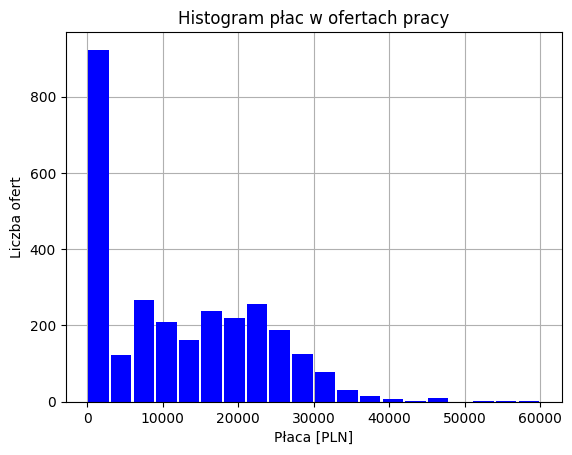

In [9]:
plt.hist(df['MidSalary'], bins=20, rwidth=0.9, color=chart_color)
plt.xlabel('Płaca [PLN]')
plt.ylabel('Liczba ofert')
plt.title('Histogram płac w ofertach pracy')
plt.show()

In [10]:
zero_values = df[df['MidSalary'] == 0].shape[0]
print(f'{zero_values / df.shape[0] * 100:.2f}% ofert ma brak informacji o wynagrodzeniu.')


32.25% ofert ma brak informacji o wynagrodzeniu.


Z histogramu płac w ofertach pracy wynika, że najwięcej ofert pracy dotyczy płac w przedziale od 0 do 5000 PLN.
Są to jednak dane niewiarygodne, gdyż bardzo wiele ofert nie podaje widełek wynagrodzenia.
Jest to zjawisko negatywnie wpływające na jakość danych. W celu przewidzenia wynagrodzenia na podstawie pewnych cech, nie powinniśmy 
brać pod uwagę ofert, które nie podają widełek wynagrodzenia, ponieważ zaburzy nam drastycznie wyniki modelu.

In [78]:
df = df[df['MidSalary'] > 0]

from ydata_profiling import ProfileReport

fixed_df = df.copy()
fixed_df = fixed_df.drop(columns=['ID', 'OfferPortalCompanyId'])

profile = ProfileReport(fixed_df, title='Raport o wynagrodzeniach w branży IT', explorative=True)
profile.to_file("raport.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Po usunięciu ofert, które nie podają widełek wynagrodzenia, zobaczmy jak wygląda histogram płac w ofertach pracy.

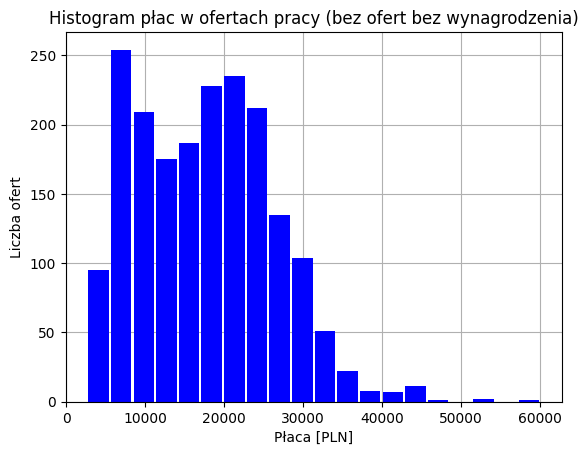

In [12]:
plt.hist(df['MidSalary'], bins=20, rwidth=0.9, color=chart_color)
plt.xlabel('Płaca [PLN]')
plt.ylabel('Liczba ofert')
plt.title('Histogram płac w ofertach pracy (bez ofert bez wynagrodzenia)')
plt.show()

In [13]:
print(df['MidSalary'].describe())
print('Median: ', df['MidSalary'].median())


count     1937.000000
mean     17637.343314
std       8578.942630
min       2664.000000
25%      10000.000000
50%      17500.000000
75%      23520.000000
max      60000.000000
Name: MidSalary, dtype: float64
Median:  17500.0


Location
Remote           631
Warszawa         520
Kraków           194
Wroclaw          100
Other             87
Gdansk            69
Poznan            60
Katowice          53
Abroad            38
Łódź              34
Gliwice           25
Rzeszów           21
Gdynia            20
Szczecin          13
Lublin            10
Bialystok         10
Bydgoszcz          9
Zielona Góra       9
Chorzów            7
Zabierzów          7
Adamów             6
Torun              5
Bielsko-Biala      5
Tychy              3
Opole              1
dtype: int64


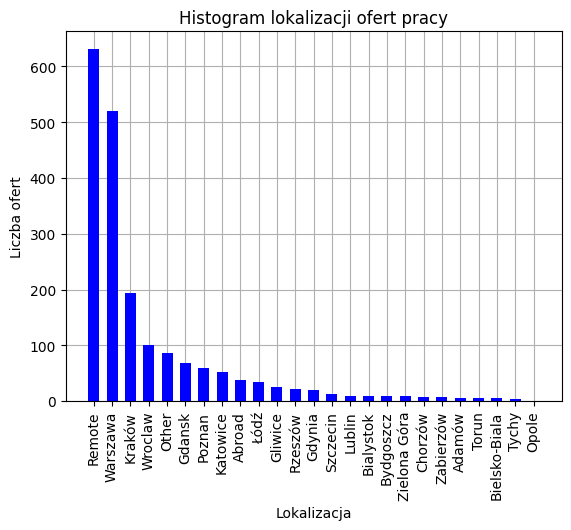

In [14]:
def plot_locations(df): 
    locations = df.groupby('Location').size().sort_values(ascending=False)

    print(locations)

    plt.title('Histogram lokalizacji ofert pracy')
    plt.xlabel('Lokalizacja')
    plt.ylabel('Liczba ofert')

    plt.xticks(rotation=90)
    plt.bar(locations.index, locations.values, color='blue', width=0.6)

plot_locations(df)

Najwięcej ofert pracy jest w "lokalizacji" zdalnej.
Jeśli chodzi o lokalizacje pracy stacjonarnej, to najwięcej ofert jest w Warszawie, Krakowie, Wrocławiu, Poznaniu i Trójmieście.

Spróbujmy dokonać analizy lokalizacji biorąc pod uwagę liczbę ludności w miastach.
Odpowiedzmy na pytanie, które miasto jest najbardziej atrakcyjne dla pracowników IT?

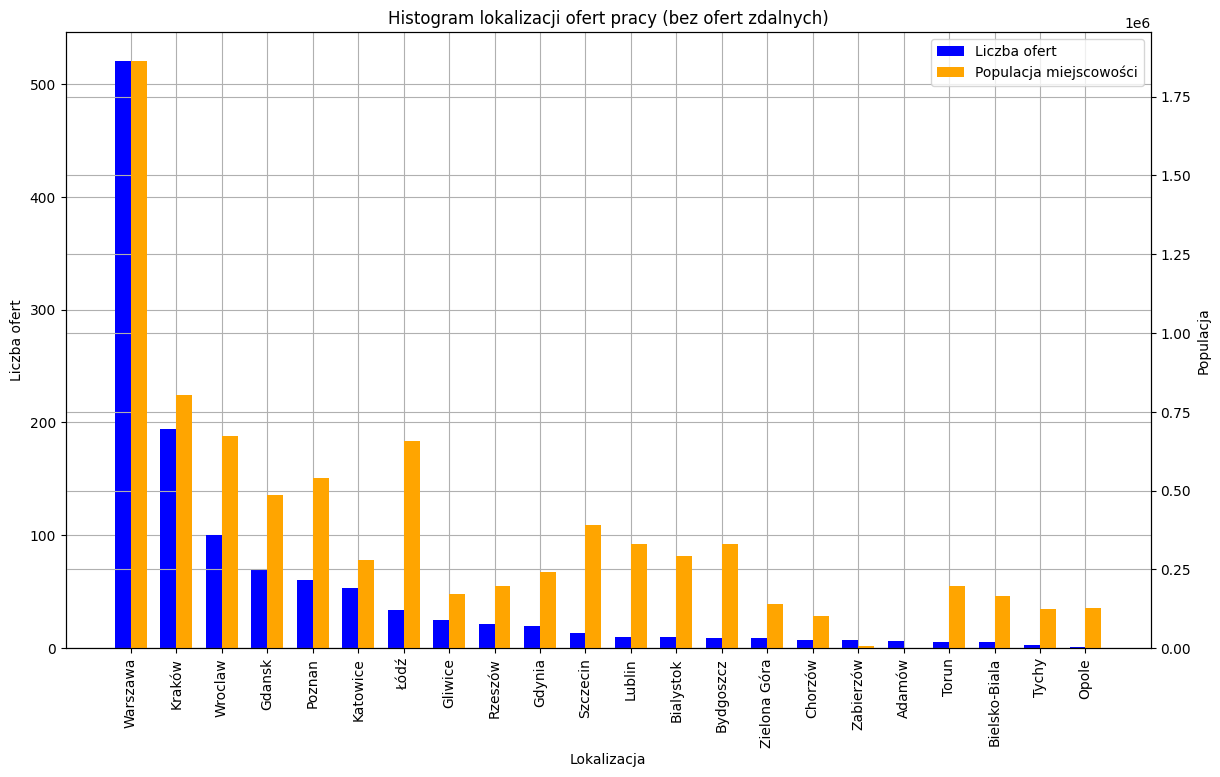

In [15]:
locations = df.groupby('Location').size().sort_values(ascending=False)
locations.drop(['Remote', 'Other', 'Abroad'], inplace=True)

city_pop_dict = {
    'Warszawa': 1_861_975,
    'Kraków': 803_282,
    'Wroclaw': 674_079,
    'Łódź': 658_444,
    'Poznan': 541_316,
    'Gdansk': 486_345,
    'Szczecin': 391_566,
    'Lublin': 331_243,
    'Bydgoszcz': 330_038,
    'Bialystok': 292_600,
    'Katowice': 280_190,
    'Gdynia': 242_874,
    'Czestochowa': 208_282,
    'Radom': 197_848,
    'Rzeszów': 197_181,
    'Torun': 195_690,
    'Sosnowiec': 189_178,
    'Kielce': 183_885,
    'Gliwice': 171_023,
    'Olsztyn': 168_212,
    'Bielsko-Biala': 166_765,
    'Zabrze': 155_430,
    'Bytom': 149_576,
    'Zielona Góra': 139_278,
    'Rybnik': 131_744,
    'Ruda Śląska': 131_532,
    'Opole': 126_458,
    'Tychy': 123_105,
    'Gorzów Wielkopolski': 116_436,
    'Dąbrowa Górnicza': 114_765,
    'Elbląg': 113_567,
    'Płock': 112_483,
    'Koszalin': 104_239,
    'Tarnów': 103_960,
    'Chorzów': 103_229,
    'Zabierzów': 6_106,
    'Adamów': 63,
} # źródło: https://forumppp.pl/finanse-publiczne-i-ppp/50-najwiekszych-miast-w-polsce/

city_pop_dict = {k: v for k, v in city_pop_dict.items() if k in locations.index}

cities = locations.index
job_offers = locations.values
populations = [city_pop_dict[city] for city in cities]

x = np.arange(len(cities))
width = 0.35

fig, ax1 = plt.subplots(figsize=(14, 8))

bars1 = ax1.bar(x - width/2, job_offers, width, label='Liczba ofert', color='blue')

ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, populations, width, label='Populacja miejscowości', color='orange')

ax1.set_xlabel('Lokalizacja')
ax1.set_ylabel('Liczba ofert')
ax2.set_ylabel('Populacja')
plt.title('Histogram lokalizacji ofert pracy (bez ofert zdalnych)')

ax1.set_xticks(x)
ax1.set_xticklabels(cities, rotation=90)

fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.show()


Możemy zauważyć, że w niektórych miastach, które są bardziej zaludnione jest mniej ofert pracy niż w tych mniej zaludnionych. Może to sugerować, że korelacja między liczbą ludności a liczbą ofert pracy nie zawsze będzie występować.

In [16]:
remote_to_all_proportion = df['Location'].where(df['Location'] == 'Remote').count() / df['Location'].count()

print(f'Procent ofert prac zdalnych: {remote_to_all_proportion * 100:.2f}%')

Procent ofert prac zdalnych: 32.58%


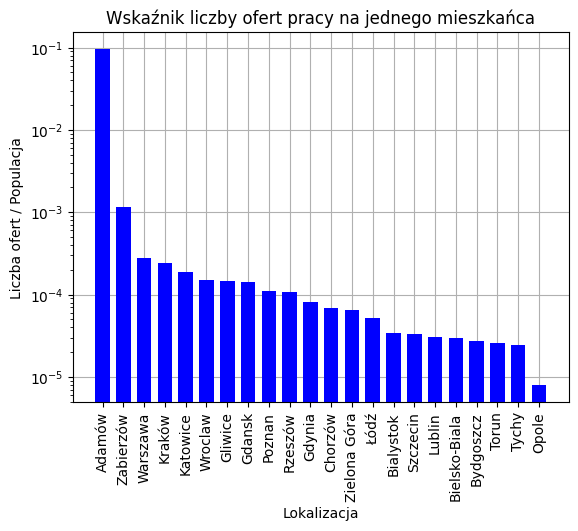

In [17]:
pop_per_job = [job/pop for pop, job in zip(populations, job_offers)]

pop_per_job, cities_job = zip(*sorted(zip(pop_per_job, cities), reverse=True))

x_pop_per_job = np.arange(len(cities_job))


plt.xlabel('Lokalizacja')
plt.ylabel('Liczba ofert / Populacja')
plt.title('Wskaźnik liczby ofert pracy na jednego mieszkańca')
plt.xticks(x_pop_per_job)
plt.xticks(rotation=90)
plt.yscale('log')
plt.bar(cities_job, pop_per_job, width=0.7, color='blue')

plt.show()

Najlepiej mają programiści z Adamowa. Jest to jednak wieś w województwie mazowieckim, kilkanaście kilometrów od Warszawy. Znadują się tam tylko wyłącznie hurtownie i magazyny, więc jest to zjawisko nietypowe.

Do wizualizacji wskaźnika zastosowano skalę logarytmiczną tak aby przypadek Adamowa i Zabierzowa nie zaburzał czytelności wykresu.

In [18]:
abroad_to_all_proportion = df['Location'].where(df['Location'] == 'Abroad').count() / df['Location'].count()

print(f'Procent ofert pracy za granicą: {abroad_to_all_proportion * 100:.2f}%')

Procent ofert pracy za granicą: 1.96%


Z opisu statystycznego wynagrodzeń w ofertach pracy wynika, że:
- średnie wynagrodzenie wynosi 17637 PLN
- mediana wynagrodzeń wynosi 17500 PLN
- minimalne wynagrodzenie wynosi 2664 PLN

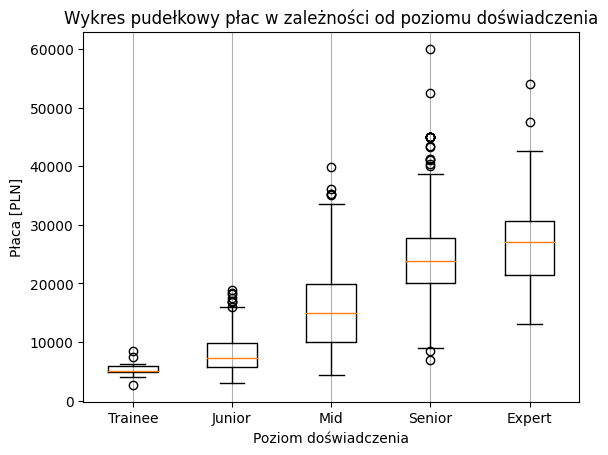

In [19]:
exp_levels = df['ExpLevel'].unique()

mean_salaries = df.groupby('ExpLevel')['MidSalary'].mean()

sorted_exp_levels = mean_salaries.sort_values().index

data = [df[df['ExpLevel'] == exp_level]['MidSalary'] for exp_level in sorted_exp_levels]

plt.boxplot(data, labels=sorted_exp_levels)

plt.title('Wykres pudełkowy płac w zależności od poziomu doświadczenia')
plt.suptitle('')
plt.grid(axis='y')
plt.xlabel('Poziom doświadczenia')
plt.ylabel('Płaca [PLN]')
plt.show()

In [20]:
mean_salaries.sort_values(ascending=False, inplace=True)
mean_salaries

ExpLevel
Expert     26890.650602
Senior     24242.493808
Mid        15429.122905
Junior      8154.893617
Trainee     5232.709677
Name: MidSalary, dtype: float64

## Im wyższy poziom doświadczenia, tym wyższe wynagrodzenie.
Z wykresu pudełkowego wyraźnie widać, że poziom doświadczenia ma zdecydowany wpływ na wynagrodzenie.

In [21]:
categories = df['Category'].unique()
categories

array(['data', 'businessAnalyst', 'erp', 'marketing', 'backend',
       'fullstack', 'architecture', 'ux', 'other', 'sales', 'testing',
       'electronics', 'devops', 'embedded', 'frontend',
       'sysAdministrator', 'projectManager', 'security', 'support',
       'robotics', 'automation', 'productManagement', 'customerService',
       'finance', 'officeAdministration', 'logistics',
       'businessIntelligence', 'consulting', 'mobile',
       'artificialIntelligence', 'agile', 'gameDev', 'telecommunication',
       'hr', 'law', None], dtype=object)

In [22]:
mean_salaries = df.groupby('Category')['MidSalary'].mean()
sorted_categories = mean_salaries.sort_values().index

data = [df[df['Category'] == category]['MidSalary'] for category in sorted_categories]

category_salaries = pd.DataFrame(mean_salaries)
category_salaries = category_salaries.sort_values(by='MidSalary', ascending=False)

category_salaries

,MidSalary
Category,
artificialIntelligence,27135.552632
architecture,25766.500000
data,23632.850394
agile,22725.000000
backend,21734.632479
businessIntelligence,21438.657895
mobile,21292.260000
gameDev,21287.250000
security,21256.121622


Z analizy wynagrodzeń w zależności od kategorii (specjalizacji) ofert wynika, że największe zarobki są w kategorii
- Sztuczna inteligencja - 27100 PLN
- Architekt kodu - 25800 PLN
- Analiza danych - 23600 PLN
- Agile / Scrum - 22700 PLN
- Backend - 21700 PLN

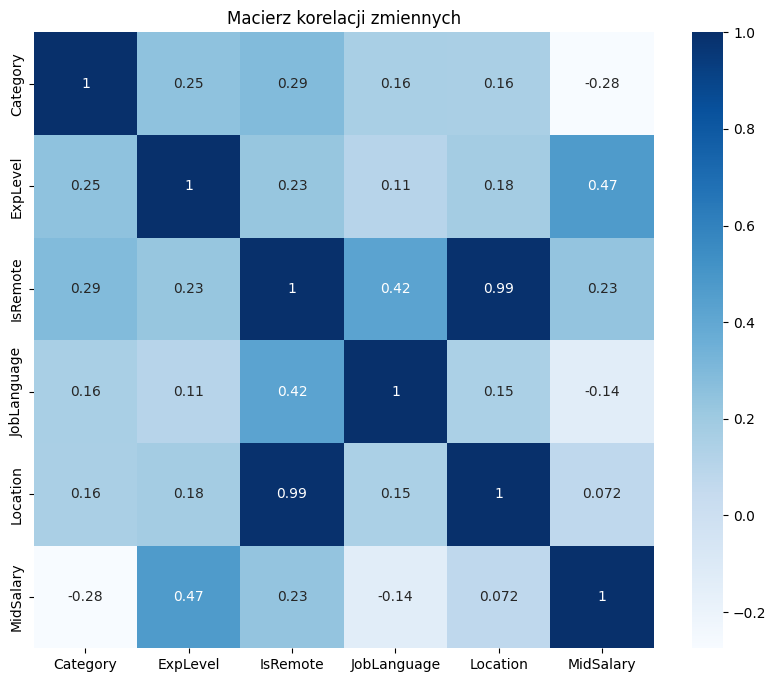

In [74]:
import seaborn as sns

def show_correlation_matrix(corr_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, 
                yticklabels=correlation_matrix.keys(), 
                annot=True,
                cmap='Blues')
    plt.title('Macierz korelacji zmiennych')
    plt.show()

correlation_matrix = pd.DataFrame({
    'Category': [1.000, 0.252, 0.288, 0.163, 0.156, -0.275],
    'ExpLevel': [0.252, 1.000, 0.225, 0.108, 0.181, 0.471],
    'IsRemote': [0.288, 0.225, 1.000, 0.423, 0.994, 0.234],
    'JobLanguage': [0.163, 0.108, 0.423, 1.000, 0.151, -0.135],
    'Location': [0.156, 0.181, 0.994, 0.151, 1.000, 0.072],
    'MidSalary': [-0.275, 0.471, 0.234, -0.135, 0.072, 1.000],
})

show_correlation_matrix(correlation_matrix)

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

def generate_model(df, dest, categorical_features, numerical_features):
    X = df[categorical_features + numerical_features]
    y = df[dest]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
    transformers = [
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
    
    if len(numerical_features) > 0:
        transformers.append(('num', 'passthrough', numerical_features))
    
    preprocessor = ColumnTransformer(transformers=transformers)
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print('Score: ', model.score(X_test, y_test))
    
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, alpha=0.3, color=chart_color)
    plt.grid(zorder=-1)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.xlabel('Wartość rzeczywista')
    plt.ylabel('Wartość przewidziana')
    plt.title('Porównanie wartości rzeczywistych i przewidzianych')
    plt.show()
    
    return model, X_train, X_test, y_train, y_test

Score:  0.7372308944518545


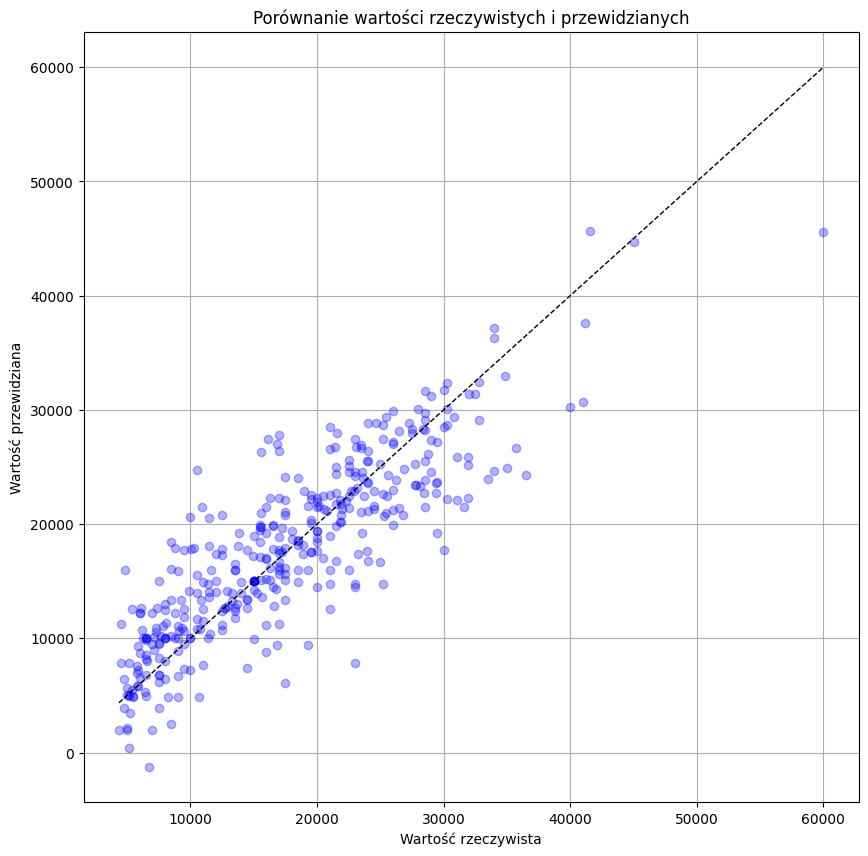

In [25]:
model, X_train, X_test, y_train, y_test = generate_model(df, 
                                                         dest=['MidSalary'], 
                                                         categorical_features=['ExpLevel', 'Technology', 'Category', 'Company'], 
                                                         numerical_features=['IsRemote'])

Model w 73% jest w stanie odpowiedzieć na podstawie podanych przez nas cech jakie jest wynagrodzenie programisty.

In [26]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Średni wynik R^2: {np.mean(cv_scores)}")

Średni wynik R^2: 0.6567658299704688


Score:  0.738945324980513


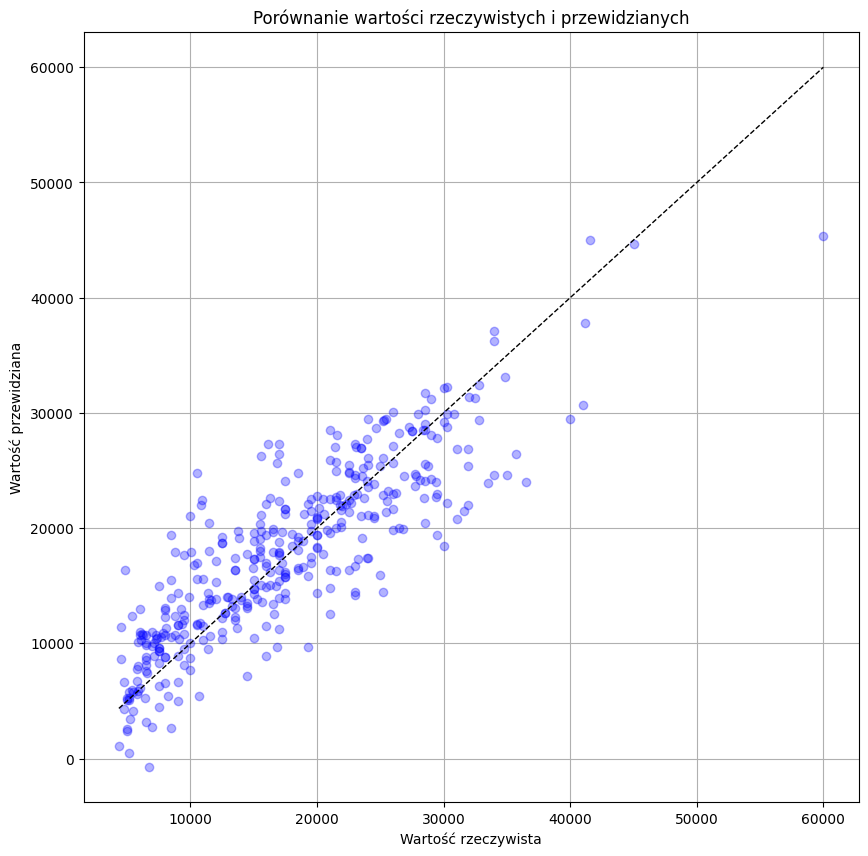

In [27]:
model, X_train, X_test, y_train, y_test = generate_model(df, 
               dest=['MidSalary'], 
               categorical_features=['ExpLevel', 'Category', 'Technology', 'Location', 'Company'], 
               numerical_features=['IsRemote'])

## Eksperymenty z modelami regresji

Score:  0.7283375512227928
Mean squared error:  20538974.825294055


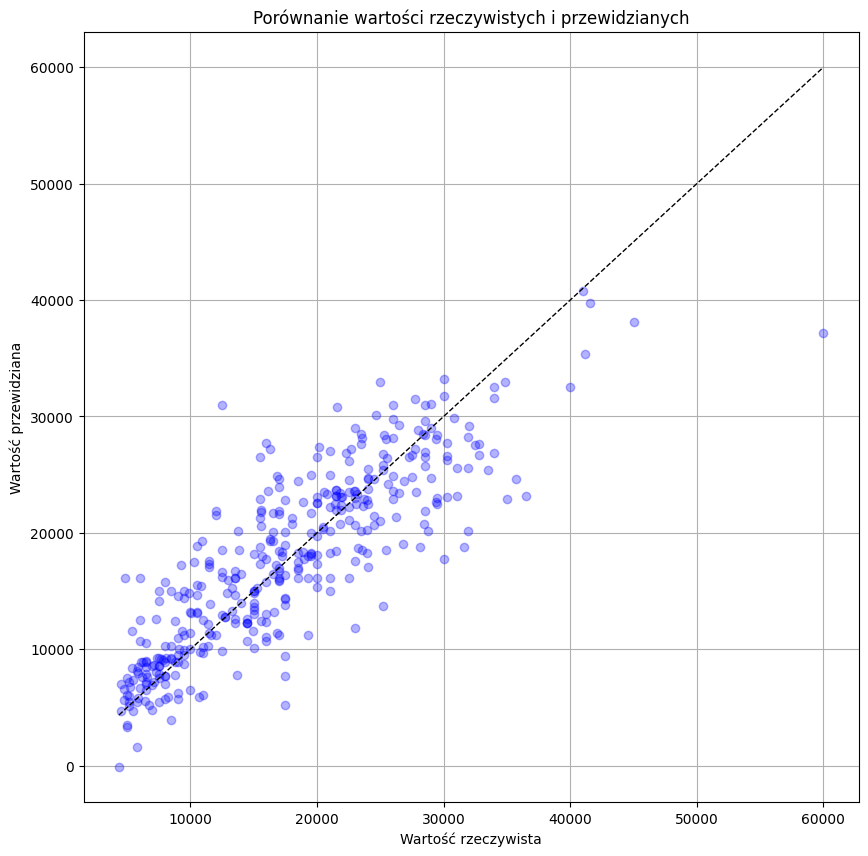

(Pipeline(steps=[('preprocessor',
                  ColumnTransformer(transformers=[('cat',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['ExpLevel', 'Category',
                                                    'Technology', 'Location',
                                                    'Company']),
                                                  ('num', 'passthrough',
                                                   ['IsRemote'])])),
                 ('poly', PolynomialFeatures()),
                 ('regressor', LinearRegression())]),
      ExpLevel           Category Technology  Location              Company   
 1476   Junior        electronics       None    Abroad           SILVERHAND  \
 1130   Expert       architecture      Azure  Warszawa       Avanade Poland   
 207    Senior           security        AWS    Remote             MANGOPAY   
 1074      Mid              sales    

In [28]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

def generate_poly_linear_model(df, dest, categorical_features, numerical_features, degree):
    X = df[categorical_features + numerical_features]
    y = df[dest]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
    
    transformers = [
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
    
    if len(numerical_features) > 0:
        transformers.append(('num', 'passthrough', numerical_features))
    
    preprocessor = ColumnTransformer(transformers=transformers)
    
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('poly', PolynomialFeatures(degree=degree)),
        ('regressor', LinearRegression())
    ])
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print('Score: ', model.score(X_test, y_test))
    print('Mean squared error: ', np.mean((y_pred - y_test) ** 2))
    
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, alpha=0.3, color=chart_color)
    plt.grid(zorder=-1)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.xlabel('Wartość rzeczywista')
    plt.ylabel('Wartość przewidziana')
    plt.title('Porównanie wartości rzeczywistych i przewidzianych')
    plt.show()
    
    return model, X_train, X_test, y_train, y_test

generate_poly_linear_model(df,
                        dest=['MidSalary'], 
                        categorical_features=['ExpLevel', 'Category', 'Technology', 'Location', 'Company'], 
                        numerical_features=['IsRemote'], 
                        degree=2)

Zobaczmy jakie cechy mają największy wpływ na wynagrodzenie.

Intercept: 1363.4712103088023
Coeffs: [7266.62175402]


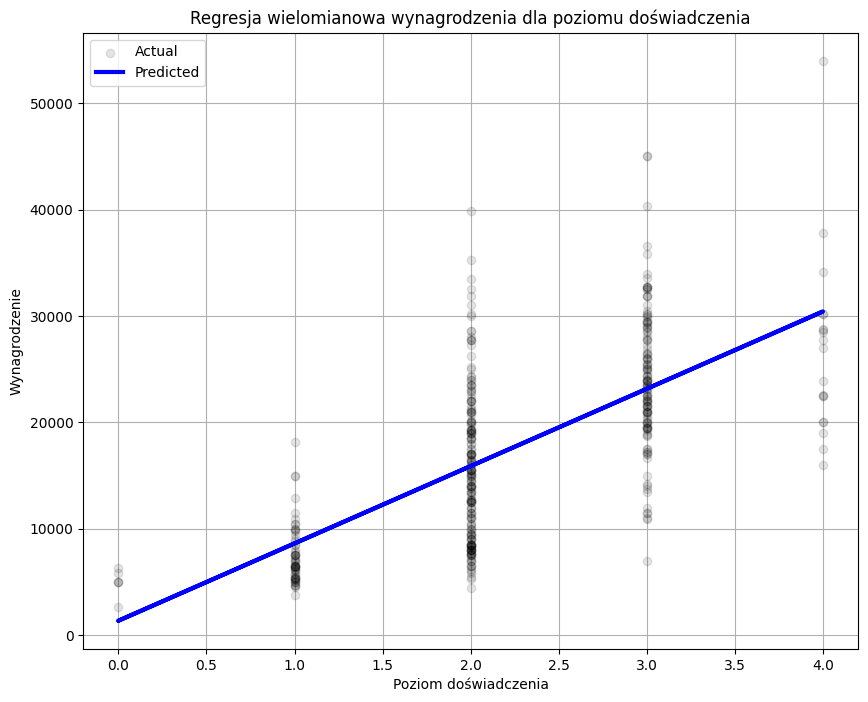

In [29]:
def exp_level_to_salary_model():
    X = df['ExpLevel'].map({ 'Trainee': 0, 'Junior': 1, 'Mid': 2, 'Senior': 3, 'Expert': 4 }).values.reshape(-1, 1)
    y = df['MidSalary']


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    intercept = model.intercept_
    coeffs = model.coef_

    print(f'Intercept: {intercept}')
    print(f'Coeffs: {coeffs}')

    plt.figure(figsize=(10, 8))

    plt.scatter(X_test, y_test, color='black', label='Actual', alpha=0.1)

    x = np.linspace(X.min(), X.max(), 1)

    plt.plot(X_test, y_pred, color=chart_color, label='Predicted', linewidth=3)


    plt.xlabel('Poziom doświadczenia')
    plt.ylabel('Wynagrodzenie')
    plt.title('Regresja wielomianowa wynagrodzenia dla poziomu doświadczenia')
    plt.legend()
    plt.show()

exp_level_to_salary_model()

In [30]:
importance = np.reshape(model.named_steps['regressor'].coef_, (-1, 1))[:-1]
feature_names = model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
feature_importance = pd.DataFrame(importance, index=feature_names, columns=['Importance'])
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
feature_importance.head(20)


,Importance
Company_Snowflake,23646.175978
Company_Technosource,17071.048051
Company_KZ INSPIRE,16624.551720
Company_Chorus One,15691.282068
Company_Infopulse,15652.073102
Company_Plenti,14813.350864
Company_Harvey Nash Technology Sp. z o.o.,14320.692797
Company_RunBit,12440.234505
Company_vonRoll Infratec.com,12314.586550
Company_Be in IT,12208.265704


Z analizy cech wynika, że największy wpływ na wynagrodzenie ma wybór firmy.
Nie uważam, żeby to była dobra cecha, ponieważ chcemy przewidzieć wynagrodzenie na podstawie ogólnych cech, a nie na podstawie firmy.
Firma może chcieć zatrudniać wyłącznie najlepszych specjalistów, co wpłynie na wysokie wynagrodzenie.

Usuńmy z listy cechy związane z firmą, gdyż chcemy zobaczyć bardziej ogólne cechy, które wpływają na wynagrodzenie.

In [31]:
feature_importance[~feature_importance.index.str.contains('Company')].head(20)

,Importance
ExpLevel_Expert,9802.344368
Location_Abroad,8765.552948
Technology_Pentesting,8680.039309
Technology_CI/CD,8623.488387
Technology_Android,7991.587167
Technology_iOS,7204.080950
Technology_React native,7101.548261
Technology_ORACLE,6280.550518
Technology_BeyondTrust,6213.521155
Category_businessIntelligence,5867.803200


In [32]:
feature_list = ['Company', 'ExpLevel', 'Category', 'Location', 'Technology', 'IsRemote']

for feature in feature_list:
    print(feature)
    print(feature_importance[feature_importance.index.str.startswith(feature)].head(20))

Company
                                             Importance
Company_Snowflake                          23646.175978
Company_Technosource                       17071.048051
Company_KZ INSPIRE                         16624.551720
Company_Chorus One                         15691.282068
Company_Infopulse                          15652.073102
Company_Plenti                             14813.350864
Company_Harvey Nash Technology Sp. z o.o.  14320.692797
Company_RunBit                             12440.234505
Company_vonRoll Infratec.com               12314.586550
Company_Be in IT                           12208.265704
Company_Transition Technologies PSC S.A.   11571.282130
Company_Directio Sp. z o.o.                11391.280928
Company_First Derivative                   11140.362481
Company_Varwise                            10754.355686
Company_Wipro IT Services                  10427.762438
Company_int2code GmbH                      10257.026543
Company_Consult Red                     

In [33]:
feature_importance

,Importance
Company_Snowflake,23646.175978
Company_Technosource,17071.048051
Company_KZ INSPIRE,16624.551720
Company_Chorus One,15691.282068
Company_Infopulse,15652.073102
...,...
Company_Biuro Pośrednictwa Pracy Elżbieta Soberka,-11494.141792
Company_Imperia HR,-12396.344251
Company_UBIQUITY SERVICE,-12570.540515
Company_Coople,-12812.790799


<BarContainer object of 5 artists>

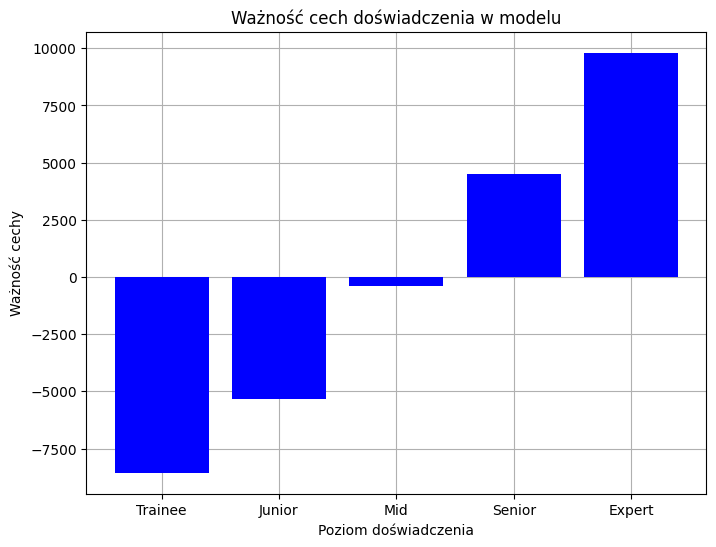

In [34]:
exp_feature = feature_importance[feature_importance.index.str.startswith('ExpLevel')]

exp_feature = exp_feature.sort_values(by='Importance', ascending=True)
exp_feature.index = exp_feature.index.str.replace('ExpLevel_', '')

plt.figure(figsize=(8, 6))
plt.xlabel('Poziom doświadczenia')
plt.ylabel('Ważność cechy')
plt.title('Ważność cech doświadczenia w modelu')
plt.bar(exp_feature.index, exp_feature['Importance'], color=chart_color)

<BarContainer object of 5 artists>

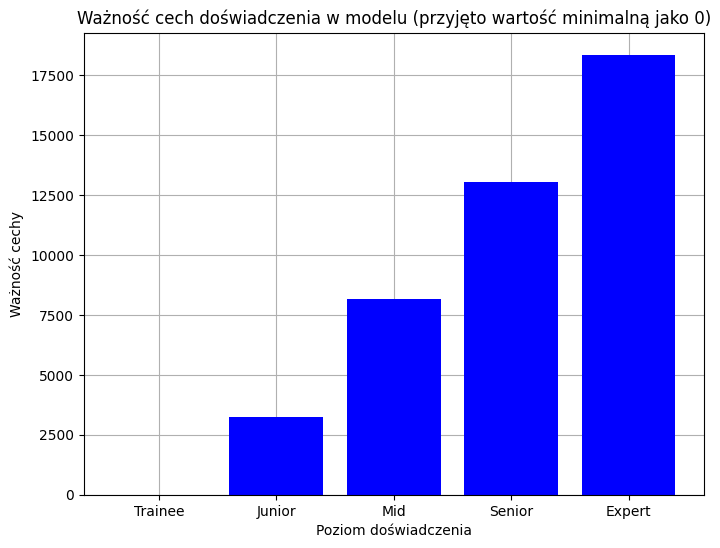

In [35]:
min_val = exp_feature['Importance'].min()
exp_feature['Importance'] = exp_feature['Importance'] + abs(min_val)

plt.figure(figsize=(8, 6))
plt.xlabel('Poziom doświadczenia')
plt.ylabel('Ważność cechy')
plt.title('Ważność cech doświadczenia w modelu (przyjęto wartość minimalną jako 0)')
plt.bar(exp_feature.index, exp_feature['Importance'], color=chart_color)

In [54]:
zero_salary_df = prepare_dataframe(records)
zero_salary_df = zero_salary_df[zero_salary_df['MidSalary'] == 0]
zero_salary_df = zero_salary_df.drop(columns=['SalaryFrom', 'SalaryTo'])

zero_salary_df

,ID,Name,ExpLevel,OfferPortalCompanyId,Category,JobLanguage,Location,IsRemote,Technology,Company,MidSalary
3,126,ROCKWOOL,Mid,2,support,,Poznan,False,None,ROCKWOOL,0.0
24,282,Edge One Solutions Sp. z o.o.,Senior,2,other,,Remote,True,None,Edge One Solutions Sp. z o.o.,0.0
29,368,Edge One Solutions Sp. z o.o.,Mid,2,businessAnalyst,,Remote,True,None,Edge One Solutions Sp. z o.o.,0.0
31,386,Hitachi Energy,Mid,2,productManagement,en,Kraków,False,None,Hitachi Energy,0.0
48,469,Edge One Solutions Sp. z o.o.,Mid,2,testing,,Remote,True,None,Edge One Solutions Sp. z o.o.,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2849,65625,Full Stack Software Developer C++,Mid,4,None,pl,Poznan,False,,OPTOPOL Technology Sp. z o.o. - Bogdani,0.0
2850,65626,Programista SQL (moduł sprzedażowo-logistyczny),Mid,4,None,pl,Warszawa,False,,Asseco Business Solutions S.A.,0.0
2853,65629,Ruby - Backend Developer,Mid,4,backend,pl,Warszawa,False,,Yieldbird Sp. z o.o.,0.0
2854,65630,Database Administrator,Mid,4,data,pl,Warszawa,False,,SOLBEG,0.0


Location
Warszawa         331
Kraków           127
Other             99
Remote            61
Wroclaw           52
Gdansk            48
Łódź              42
Poznan            36
Katowice          27
Gliwice           21
Zielona Góra      12
Bialystok          9
Rzeszów            8
Lublin             7
Opole              6
Bydgoszcz          6
Torun              6
Budapest           6
Gdynia             6
Szczecin           5
Tychy              3
Abroad             2
Bielsko-Biala      1
Zabierzów          1
dtype: int64


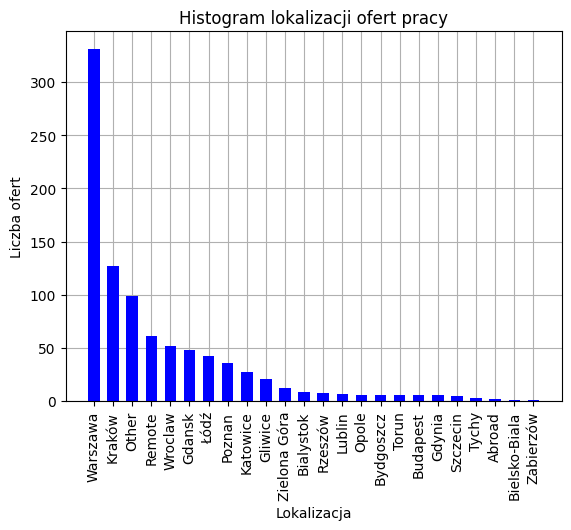

In [55]:
plot_locations(zero_salary_df[zero_salary_df['MidSalary'] == 0])

Możemy nasz model zapytać o kilka rzeczy, zobaczmy jak odpowie

In [56]:
def predict_salary(model, offers):
    X = offers[['ExpLevel', 'Category', 'Technology', 'Location', 'Company', 'IsRemote']]
    y_pred = model.predict(X)
    
    offers['MidSalary'] = y_pred
    
    return offers

zero_salary_pred = predict_salary(model, zero_salary_df)
zero_salary_pred

,ID,Name,ExpLevel,OfferPortalCompanyId,Category,JobLanguage,Location,IsRemote,Technology,Company,MidSalary
3,126,ROCKWOOL,Mid,2,support,,Poznan,False,None,ROCKWOOL,11186.043088
24,282,Edge One Solutions Sp. z o.o.,Senior,2,other,,Remote,True,None,Edge One Solutions Sp. z o.o.,19413.473696
29,368,Edge One Solutions Sp. z o.o.,Mid,2,businessAnalyst,,Remote,True,None,Edge One Solutions Sp. z o.o.,17531.079332
31,386,Hitachi Energy,Mid,2,productManagement,en,Kraków,False,None,Hitachi Energy,14229.759290
48,469,Edge One Solutions Sp. z o.o.,Mid,2,testing,,Remote,True,None,Edge One Solutions Sp. z o.o.,15707.391243
...,...,...,...,...,...,...,...,...,...,...,...
2849,65625,Full Stack Software Developer C++,Mid,4,None,pl,Poznan,False,,OPTOPOL Technology Sp. z o.o. - Bogdani,17187.448623
2850,65626,Programista SQL (moduł sprzedażowo-logistyczny),Mid,4,None,pl,Warszawa,False,,Asseco Business Solutions S.A.,16381.446434
2853,65629,Ruby - Backend Developer,Mid,4,backend,pl,Warszawa,False,,Yieldbird Sp. z o.o.,17523.608117
2854,65630,Database Administrator,Mid,4,data,pl,Warszawa,False,,SOLBEG,18243.273740


In [57]:
zero_salary_pred.describe()

,ID,OfferPortalCompanyId,MidSalary
count,922.000000,922.000000,922.000000
mean,43362.016269,3.253796,15767.664338
std,28329.940375,0.967783,5591.348955
min,126.000000,2.000000,335.135278
25%,8620.250000,2.000000,11768.803472
50%,64625.000000,4.000000,16224.199517
75%,65219.750000,4.000000,19932.139254
max,65634.000000,4.000000,30789.605003


In [58]:
median_salary = zero_salary_pred['MidSalary'].median()
f'Mediana: {median_salary:.2f} zł'

'Mediana: 16224.20 zł'

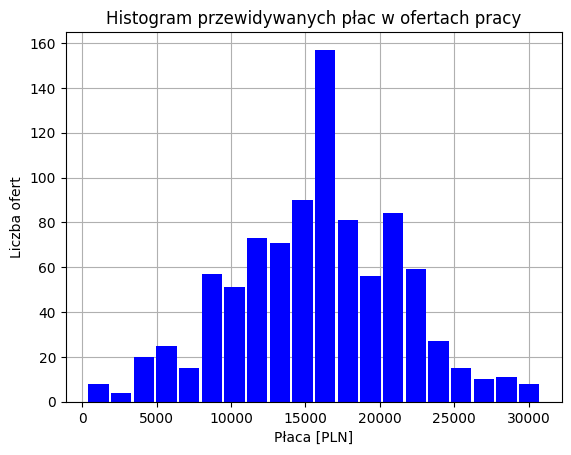

In [59]:
def plot_predicted_salaries(df):
    plt.hist(df['MidSalary'], bins=20, rwidth=0.9, color=chart_color)
    plt.xlabel('Płaca [PLN]')
    plt.ylabel('Liczba ofert')
    plt.title('Histogram przewidywanych płac w ofertach pracy')
    plt.show()


plot_predicted_salaries(zero_salary_pred)

In [62]:
zero_salary_pred = zero_salary_pred.drop(columns=['OfferPortalCompanyId', 'ID'])

profile = ProfileReport(zero_salary_pred, title='Raport o przewidywanych wynagrodzeniach w branży IT', explorative=True)
profile.to_file("raport_przewidzenie_wynagrodzenia.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

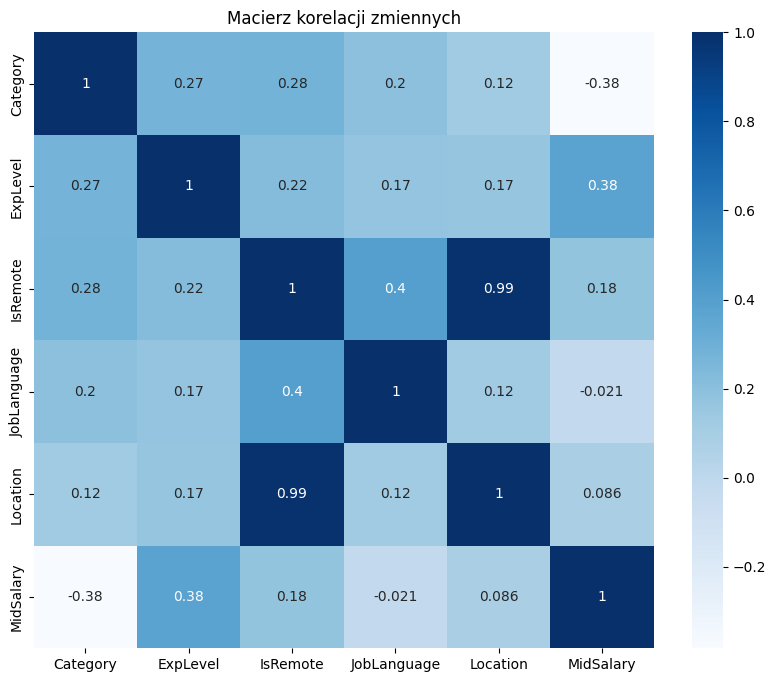

In [87]:
zero_salary_correration_matrix = pd.DataFrame({
    'Category': [1.000, 0.272, 0.280, 0.197, 0.125, -0.383],
    'ExpLevel': [0.272, 1.000, 0.218, 0.170, 0.168, 0.379],
    'IsRemote': [0.280, 0.218, 1.000, 0.404, 0.988, 0.176],
    'JobLanguage': [0.197, 0.170, 0.404, 1.000, 0.122, -0.021],
    'Location': [0.125, 0.168, 0.988, 0.122, 1.000, 0.086],
    'MidSalary': [-0.383, 0.379, 0.176, -0.021, 0.086, 1.000],
})

show_correlation_matrix(zero_salary_correration_matrix)

In [61]:
questions = [
    {
        'ExpLevel': 'Junior',
        'Category': 'IT',
        'Company': 'Google',
        'JobLanguage': 'en',
        'Location': 'Wroclaw',
        'Technology': 'Python',
        'IsRemote': 1
    },
    {
        'ExpLevel': 'Mid',
        'Category': 'IT',
        'Company': 'Google',
        'JobLanguage': 'en',
        'Location': 'Wroclaw',
        'Technology': 'Python',
        'IsRemote': 1
    },
    {
        'ExpLevel': 'Mid',
        'Category': 'businessIntelligence',
        'Company': 'Snowflake',
        'Location': 'Warszawa',
        'JobLanguage': 'pl',
        'Technology': 'Python',
        'IsRemote': 1
    },
    {
        'ExpLevel': 'Senior',
        'Category': 'IT',
        'Company': 'Snowflake',
        'Location': 'Warszawa',
        'JobLanguage': 'pl',
        'Technology': 'Pentesting',
        'IsRemote': 0
    },
    {
        'ExpLevel': 'Senior',
        'Category': 'testing',
        'Company': 'Snowflake',
        'Location': 'Warszawa',
        'JobLanguage': 'pl',
        'Technology': 'Pentesting',
        'IsRemote': 1
    },
    {
        'ExpLevel': 'Senior',
        'Category': 'backend',
        'Company': '.NET',
        'Location': 'Warszawa',
        'JobLanguage': 'pl',
        'Technology': 'Pentesting',
        'IsRemote': 1
    },
    {
        'ExpLevel': 'Junior',
        'Category': 'devops',
        'Company': '.NET',
        'Location': 'Rzeszów',
        'JobLanguage': 'pl',
        'Technology': 'CI/CD',
        'IsRemote': 1
    },
]

question_df = pd.DataFrame(questions)
question_df['MidSalary'] = model.predict(question_df)

question_df

,ExpLevel,Category,Company,JobLanguage,Location,Technology,IsRemote,MidSalary
0,Junior,IT,Google,en,Wroclaw,Python,1,8460.321996
1,Mid,IT,Google,en,Wroclaw,Python,1,13398.902628
2,Mid,businessIntelligence,Snowflake,pl,Warszawa,Python,1,44884.496699
3,Senior,IT,Snowflake,pl,Warszawa,Pentesting,0,52669.938505
4,Senior,testing,Snowflake,pl,Warszawa,Pentesting,1,53527.484666
5,Senior,backend,.NET,pl,Warszawa,Pentesting,1,31929.462296
6,Junior,devops,.NET,pl,Rzeszów,CI/CD,1,23475.232492
